#Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Importing datasets

In [4]:
df_customers = pd.read_csv('Customers.csv')
df_transactions = pd.read_csv('Transactions.csv')

Preprocessing the datasets

In [5]:
ls_name = ["Customers", "Transactions"]
ls = [df_customers, df_transactions]
for l in ls:
  print(l.info(),"\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB
None 



In [6]:
df_customers.head(5)

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [7]:
df_transactions.head(5)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


Looking for missing values

In [8]:
for l in ls:
  print(l.isnull().sum(),"\n")

CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64 

TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64 



Converting Dates from string format to date format

In [9]:
df_customers['SignupDate'] = pd.to_datetime(df_customers['SignupDate'])
df_transactions['TransactionDate'] = pd.to_datetime(df_transactions['TransactionDate'])

Looking for redundant records

In [10]:
print("Transactions", df_transactions.duplicated().sum())
print("Customers", df_customers.duplicated().sum())

Transactions 0
Customers 0


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

Based on customer ID aggregating the data

In [13]:
customer_trans = df_transactions.groupby('CustomerID').agg(
  total_spent=('TotalValue', 'sum'),
  total_transactions=('TransactionID', 'count'),
  avg_transaction_value=('TotalValue', 'mean'),
  total_quantity = ('Quantity', 'sum'),
  first_transaction = ('TransactionDate', 'min'),
  last_transaction = ('TransactionDate', 'max')
 ).reset_index()

Calculating the customer's tenure

In [14]:
today_date = df_transactions["TransactionDate"].max()
df_customers["tensure_days"] = (today_date - df_customers["SignupDate"]).dt.days

Merging customer profile with aggregated transaction data

In [15]:
df_merged = pd.merge(df_customers, customer_trans, on='CustomerID', how='inner')

Encoding the categorical variables

In [17]:
merged_df = pd.get_dummies(df_merged, columns=["Region"], drop_first=True)

Dropping columns which are not required in the training

In [18]:
merged_df.drop(columns=["CustomerID", "CustomerName", "SignupDate", "first_transaction", "last_transaction"], inplace=True)


In [19]:
merged_df.head(10)

,tensure_days,total_spent,total_transactions,avg_transaction_value,total_quantity,Region_Europe,Region_North America,Region_South America
0,902,3354.52,5,670.904000,12,False,False,True
1,1049,1862.74,4,465.685000,10,False,False,False
2,296,2725.38,4,681.345000,14,False,False,True
3,811,5354.88,8,669.360000,23,False,False,True
4,866,2034.24,3,678.080000,7,False,False,False
5,356,4227.57,4,1056.892500,12,False,False,True
6,924,2579.82,3,859.940000,8,False,False,False
7,350,4271.61,10,427.161000,20,False,True,False
8,502,896.50,3,298.833333,3,True,False,False
9,744,1717.55,4,429.387500,12,True,False,False


Standardizing the data

In [21]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_df)


Calculating the optimal number of clusters using the DB Index

In [22]:
db_scores = []
cluster_range = range(2,11)

In [23]:
for k in cluster_range:
  kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
  cluster_labels = kmeans.fit_predict(scaled_data)
  db_score = davies_bouldin_score(scaled_data, cluster_labels)
  db_scores.append(db_score)

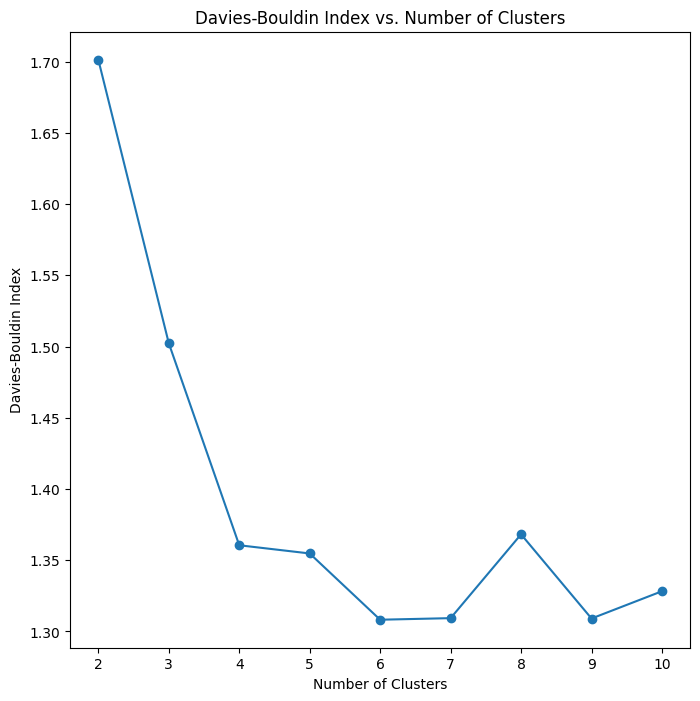

In [28]:
plt.figure(figsize=(8, 8))
plt.plot(cluster_range, db_scores, marker='o')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.show()

Minimum DB Score tells the best value for number of clusters

In [29]:
optimal_clusters = cluster_range[np.argmin(db_scores)]

In [30]:
optimal_clusters

6

Applying K means clustering

In [32]:
final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
df_merged["Cluster"] = final_kmeans.fit_predict(scaled_data)

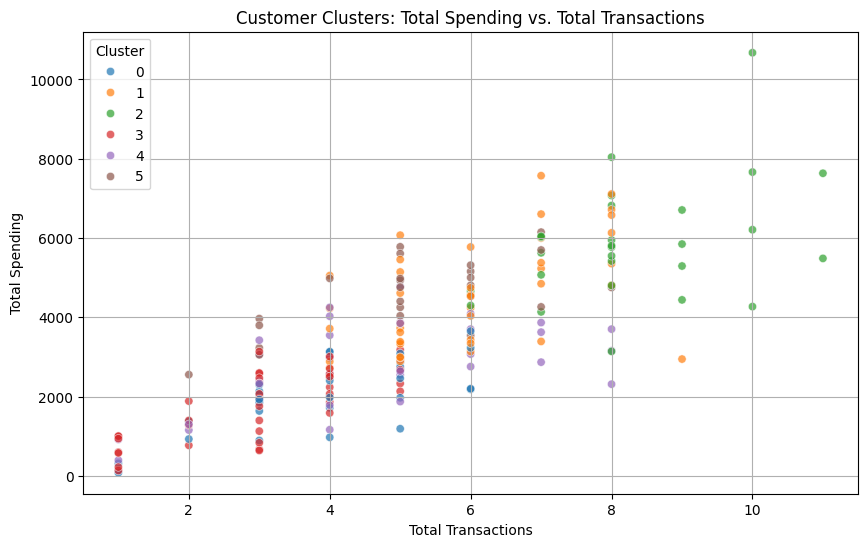

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=merged_df["total_transactions"],
    y=merged_df["total_spent"],
    hue=merged_df["Cluster"],
    palette="tab10",
    alpha=0.7
)
plt.xlabel("Total Transactions")
plt.ylabel("Total Spending")
plt.title("Customer Clusters: Total Spending vs. Total Transactions")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

<ipython-input-34-05eeb0bccea6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=merged_df["Cluster"], palette="tab10")


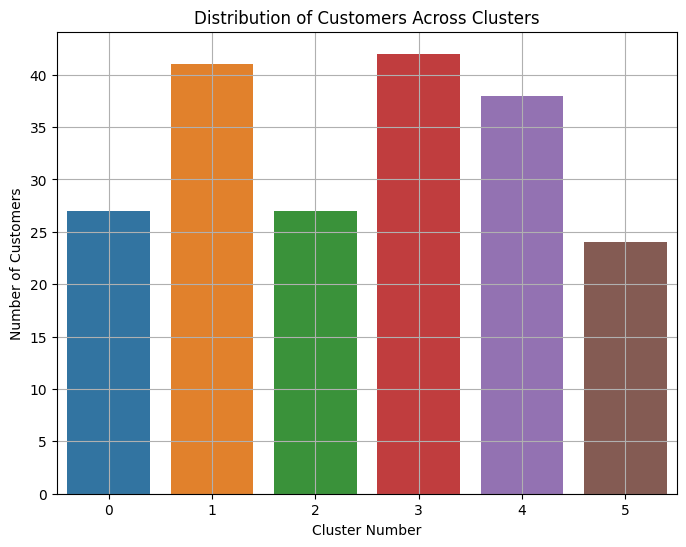

Optimal Clusters: 6
Davies-Bouldin Index: 1.3081951126099778


In [34]:
plt.figure(figsize=(8, 6))
sns.countplot(x=merged_df["Cluster"], palette="tab10")
plt.xlabel("Cluster Number")
plt.ylabel("Number of Customers")
plt.title("Distribution of Customers Across Clusters")
plt.grid(True)
plt.show()

# Print optimal clusters and DB Index
print(f"Optimal Clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index: {min(db_scores)}")

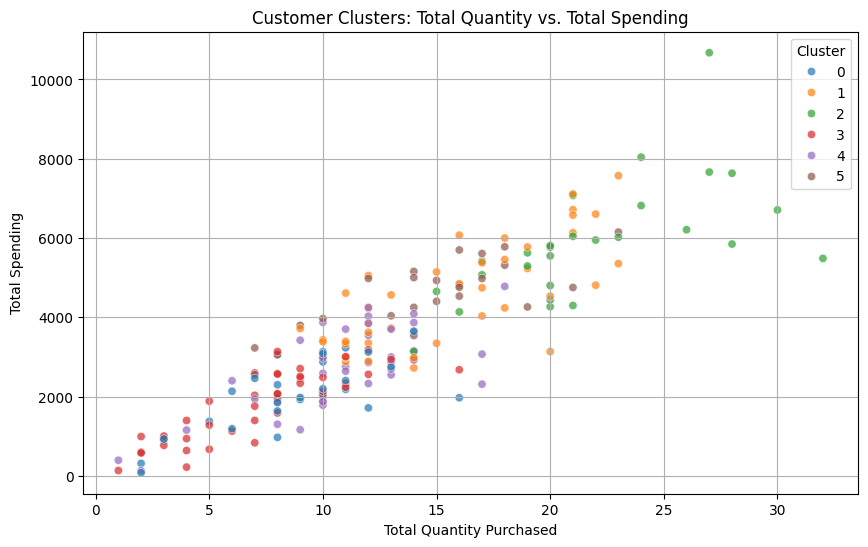

Optimal Clusters: 6
Davies-Bouldin Index: 1.3081951126099778


In [35]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=merged_df["total_quantity"],
    y=merged_df["total_spent"],
    hue=merged_df["Cluster"],
    palette="tab10",
    alpha=0.7
)
plt.xlabel("Total Quantity Purchased")
plt.ylabel("Total Spending")
plt.title("Customer Clusters: Total Quantity vs. Total Spending")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

# Print optimal clusters and DB Index
print(f"Optimal Clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index: {min(db_scores)}")